# ECE 590 AI Security and Privacy: Model training and fine-tuning
### Hiep Nguyen, Jiechen Li

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torchvision.transforms.functional as TF
import random
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.backends.mps.is_available():
        device = torch.device("mps")
print(device)

mps


## Load data

In [21]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into training and validation sets
train_set, val_set = random_split(train_data, [40000, 10000])

# Define dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Define helper functions to be used during experiments

In [22]:
# This function evaluates a model's accuracy on the validation set
# Optionally, one can pass an adversarial patch as an argument to evaluate the model's performance against a patch attack
def eval(model, patch=None, target_class=None):
  # Stats to use to calculate accuracy after the eval loop
  total_correct = 0
  total = 0
  total_target = 0
  # Put model on GPU and switch to eval mode
  model = model.to(device)
  model.eval()
  # Evaluation loop
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
      # Put data on GPU
      images = images.to(device)
      if patch is not None:
        images = apply(patch, images)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      predictions = torch.argmax(predictions, dim=1)
      # Update validation accuracy information
      total += len(images)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
      if target_class is not None:
        target = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
        num_target = (predictions == target).float().sum().item()
        total_target += num_target
  # If evaluating the effects of a targeted patch attach, it is nice to see whether or not the model is classifying lots of examples to the target class
  if target_class is not None:
    target_percentage = total_target / total
    print(f"Percentage of samples predicted as target class {target_class}: {100 * target_percentage}")
  # Calculate accuracy
  accuracy = total_correct / total
  return accuracy

In [23]:
# This function is designed to take in a pretrained ResNet model and fine-tune its weights for the CIFAR-10 dataset
# The idea is to fine-tune ResNet for the CIFAR-10 dataset (accuracy should be around 82%) and then degrade that performance via an adversarial patch attack
def fine_tune_for_cifar10(model, num_epochs=30, model_path="resnet34.pth", lr=0.01):
  # Put model on GPU and put model in training mode
  model = model.to(device)
  model.train()
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)
  best_accuracy = 0.0
  best_model_path = model_path
  # Training loop
  for i in range(num_epochs):
    # Stats to use for calculating accuracy
    total_correct = 0
    total = 0
    # Iterate through each batch of data
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on GPU
      images = images.to(device)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      # Calculate loss for the batch
      loss = criterion(predictions, labels)
      # Gradient descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Update training accuracy information
      total += len(images)
      predictions = torch.argmax(predictions, dim=1)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
    scheduler.step()  # Update the learning rate

    # Print training accuracy
    print(f"Epoch {str(i + 1)}: Training accuracy = {str(total_correct / total)}")
    # Print validation accuracy
    val_accuracy = eval(model, patch=None, target_class=None)
    print(f"Validation accuracy: {str(val_accuracy)}")

    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      torch.save(model.state_dict(), best_model_path)
      print(f"Saved new best model with accuracy: {best_accuracy:.4f}")

In [24]:
# Apply patch to a batch of images
def apply(patch, batch_of_images):
  num_images = batch_of_images.shape[0]
  patch_size = patch.shape[1]
  # Iterate through each image in the batch
  for i in range(num_images):
    # Rotate the patch by a random number of degrees
    degree = random.uniform(0, 360)
    patch_rotated = TF.rotate(patch, angle=degree)
    # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
    # This coordinate will be where the top left corner of the rotated patch goes
    top_left_x = random.randint(0, 31 - patch_size)
    top_left_y = random.randint(0, 31 - patch_size)
    # Apply the randomly rotated patch at the random location
    batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch
  return batch_of_images

In [25]:
# Function to load the best model checkpoint
def load_model(model, path, device=device):
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    return model

In [27]:
# This function fine-tunes an adversarial patch against a provided whitebox model
# Model accuracy against the patch attack is reported at each step
def generate_adversarial_patch(model, patch_size, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply):
  model = model.to(device)
  model.eval()

  # Initialize patch to all zeros
  patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
  optimizer = optim.SGD([patch], lr, momentum)
  criterion = nn.CrossEntropyLoss()
  # Optimize the patch
  for i in range(num_epochs):
    print(f"Epoch {str(i + 1)}")
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on the GPU
      images = images.to(device)
      labels = labels.to(device)
      # Apply the patch at a random location and with a random rotation for each image in the batch
      images = apply(patch, images)
      # Make predictions on the patched images
      predictions = resnet34(images)
      # For an untargeted attack, create false labels by incrementing the true labels by 1
      if target_class is None:
        false_labels = (labels + 1) % 10
      # For a targeted attack, set all the false labels to the target class
      else:
        false_labels = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
      # Tune the patch
      loss = criterion(predictions, false_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # See how the patch performs
    print(f"Target class: {target_class}")
    accuracy = eval(model, patch=patch, target_class=target_class)
    print(f"Accuracy: {str(accuracy)}\n")  
  return patch

In [28]:
# This function test the model accuracy on clean test dataset
# Optinally, if pass in an adversarial patch, this function test model accuracy, untargetted and targetted ASR
def test(model, patch=None, target_class=None, apply=apply):
  model.eval()
  total = 0
  total_correct = 0
  total_misclassified = 0
  total_targeted_hits = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      if patch is not None:
        images = apply(patch, images)

      outputs = model(images)
      predictions = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      total_correct += (predictions == labels).sum().item()
      total_misclassified += (predictions != labels).sum().item()

      if target_class is not None:
        targeted_misclassifications = ((predictions != labels) & (predictions == target_class))
        total_targeted_hits += targeted_misclassifications.sum().item()

  adversarial_accuracy = total_correct / total
  untargeted_attack_rate = total_misclassified / total

  if patch is not None:
    print(f"Model accuracy with adversarial patch: {adversarial_accuracy * 100:.2f}%")
    print(f"Untargeted attack success rate on test set: {untargeted_attack_rate * 100:.2f}%")
  else:
    print(f"Model accuracy on clean test set: {adversarial_accuracy * 100:.2f}%")

  if target_class is not None:
    targeted_attack_rate = total_targeted_hits / total
    print(f"Targeted attack success rate on test set for class {target_class}: {targeted_attack_rate * 100:.2f}%")
    return adversarial_accuracy, untargeted_attack_rate, targeted_attack_rate
  else:
    return adversarial_accuracy, untargeted_attack_rate

In [29]:
# This function takes in a patch and outputs it visually
def visualize_patch(patch):
    patch = patch.detach()
    patch = (patch - patch.min()) / (patch.max() - patch.min())  # Normalize to [0, 1]

    # Convert to numpy and transpose dimensions from [C, H, W] to [H, W, C] for visualization
    patch_np = patch.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(patch_np)
    plt.axis('off')
    plt.show()


In [30]:
# This function is used to plot the (untargeted or targeted) ASR v.s. patch size
def plot_asr_vs_patch_size(patch_sizes, asr_results):
    asr_values = [asr_results[size] * 100 for size in patch_sizes]
    plt.figure(figsize=(6,4))
    plt.plot(patch_sizes, asr_values, marker='o', linestyle='-', color='b')
    plt.title('Attack Success Rate vs Patch Size')
    plt.xlabel('Patch Size (pixels)')
    plt.ylabel('ASR (%)')
    plt.grid(True)
    plt.xticks(patch_sizes)
    plt.show()


## Fine-tune ResNet18 for CIFAR-10

In [31]:
# Load pre-trained model
resnet34 = models.resnet34(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet34.fc = nn.Linear(resnet34.fc.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet34, num_epochs=30, model_path="resnet34.pth")

# Load best model checkpoint
resnet34 = load_model(resnet34, "resnet34.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet34, patch=None, target_class=None)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/hiepnguyen/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100.0%


Epoch 1: Training accuracy = 0.28485
Validation accuracy: 0.3021
Saved new best model with accuracy: 0.3021
Epoch 2: Training accuracy = 0.371575
Validation accuracy: 0.4295
Saved new best model with accuracy: 0.4295
Epoch 3: Training accuracy = 0.466025
Validation accuracy: 0.5226
Saved new best model with accuracy: 0.5226
Epoch 4: Training accuracy = 0.5271
Validation accuracy: 0.5233
Saved new best model with accuracy: 0.5233
Epoch 5: Training accuracy = 0.56045
Validation accuracy: 0.591
Saved new best model with accuracy: 0.5910
Epoch 6: Training accuracy = 0.5963
Validation accuracy: 0.597
Saved new best model with accuracy: 0.5970
Epoch 7: Training accuracy = 0.620775
Validation accuracy: 0.6111
Saved new best model with accuracy: 0.6111
Epoch 8: Training accuracy = 0.644475
Validation accuracy: 0.6518
Saved new best model with accuracy: 0.6518
Epoch 9: Training accuracy = 0.65835
Validation accuracy: 0.655
Saved new best model with accuracy: 0.6550
Epoch 10: Training accuracy =

/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_18818/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_loc

Model accuracy on clean test set: 77.46%


(0.7746, 0.2254)

## Experiment 1: Untargeted 8x8 patch attack on ResNet18

Epoch 1
Target class: None
Accuracy: 0.3908

Epoch 2
Target class: None
Accuracy: 0.3621

Epoch 3
Target class: None
Accuracy: 0.3487

Epoch 4
Target class: None
Accuracy: 0.3266

Epoch 5
Target class: None
Accuracy: 0.326

Epoch 6
Target class: None
Accuracy: 0.3058

Epoch 7
Target class: None
Accuracy: 0.3033

Epoch 8
Target class: None
Accuracy: 0.2945

Epoch 9
Target class: None
Accuracy: 0.2966

Epoch 10
Target class: None
Accuracy: 0.284



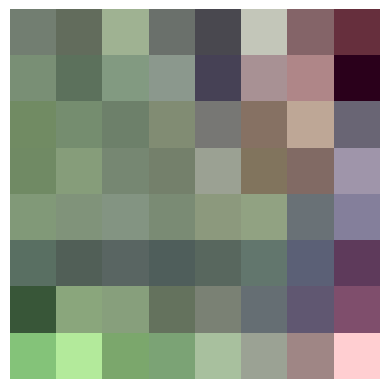

Model accuracy with adversarial patch: 33.12%
Untargeted attack success rate on test set: 66.88%

------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [12]:
# Generate adversarial patch
patch_untargeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8)

# Visualize the generated patch
visualize_patch(patch_untargeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untargeted_size8)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

## Experiment 2: The effect of patch size on untargeted attack success rate for ResNet18

Epoch 1
Target class: None
Accuracy: 0.3982

Epoch 2
Target class: None
Accuracy: 0.4104

Epoch 3
Target class: None
Accuracy: 0.4079

Epoch 4
Target class: None
Accuracy: 0.3763

Epoch 5
Target class: None
Accuracy: 0.3668

Epoch 6
Target class: None
Accuracy: 0.3642

Epoch 7
Target class: None
Accuracy: 0.3611

Epoch 8
Target class: None
Accuracy: 0.3625

Epoch 9
Target class: None
Accuracy: 0.3543

Epoch 10
Target class: None
Accuracy: 0.351



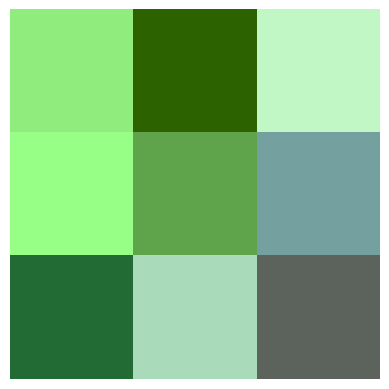

Model accuracy with adversarial patch: 38.59%
Untargeted attack success rate on test set: 61.41%
Epoch 1
Target class: None
Accuracy: 0.3857

Epoch 2
Target class: None
Accuracy: 0.3398

Epoch 3
Target class: None
Accuracy: 0.3311

Epoch 4
Target class: None
Accuracy: 0.3273

Epoch 5
Target class: None
Accuracy: 0.3238

Epoch 6
Target class: None
Accuracy: 0.3225

Epoch 7
Target class: None
Accuracy: 0.3181

Epoch 8
Target class: None
Accuracy: 0.317

Epoch 9
Target class: None
Accuracy: 0.3067

Epoch 10
Target class: None
Accuracy: 0.312



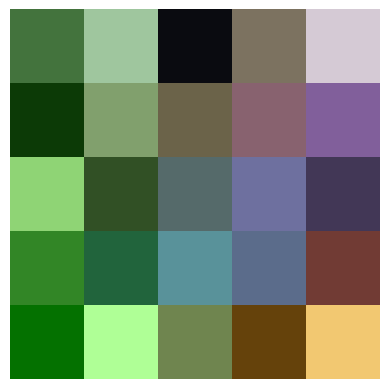

Model accuracy with adversarial patch: 34.32%
Untargeted attack success rate on test set: 65.68%
Epoch 1
Target class: None
Accuracy: 0.4109

Epoch 2
Target class: None
Accuracy: 0.3579

Epoch 3
Target class: None
Accuracy: 0.3576

Epoch 4
Target class: None
Accuracy: 0.345

Epoch 5
Target class: None
Accuracy: 0.3393

Epoch 6
Target class: None
Accuracy: 0.3391

Epoch 7
Target class: None
Accuracy: 0.3282

Epoch 8
Target class: None
Accuracy: 0.3077

Epoch 9
Target class: None
Accuracy: 0.302

Epoch 10
Target class: None
Accuracy: 0.2981



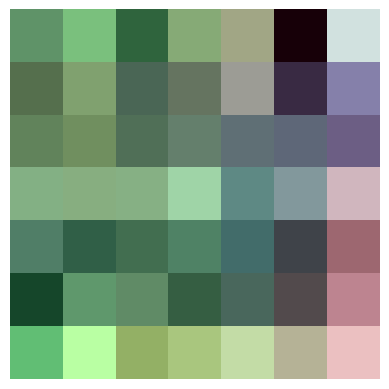

Model accuracy with adversarial patch: 33.41%
Untargeted attack success rate on test set: 66.59%
Epoch 1
Target class: None
Accuracy: 0.2673

Epoch 2
Target class: None
Accuracy: 0.2471

Epoch 3
Target class: None
Accuracy: 0.2356

Epoch 4
Target class: None
Accuracy: 0.2266

Epoch 5
Target class: None
Accuracy: 0.2209

Epoch 6
Target class: None
Accuracy: 0.2089

Epoch 7
Target class: None
Accuracy: 0.2104

Epoch 8
Target class: None
Accuracy: 0.2026

Epoch 9
Target class: None
Accuracy: 0.1993

Epoch 10
Target class: None
Accuracy: 0.1943



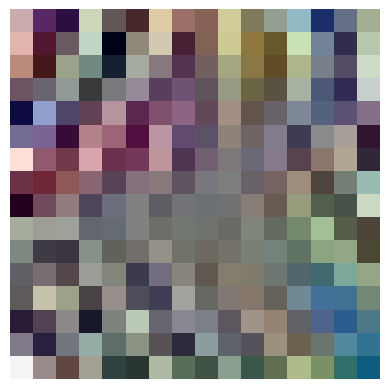

Model accuracy with adversarial patch: 21.89%
Untargeted attack success rate on test set: 78.11%


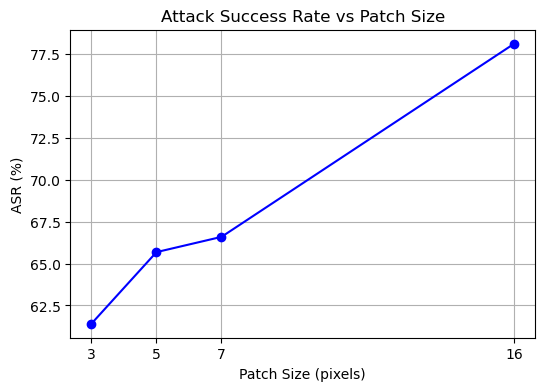


------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [13]:
# Calculate untargeteded ASR for patches of various sizes and plot patch size vs. untargeted ASR
patch_sizes = [3, 5, 7, 16]
untargetted_asr_results = {}

for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch)
  untargetted_asr_results[size] = untargetted_asr

plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

## Experiment 3: Targeted patch attacks

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 81.53
Accuracy: 0.1611

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 84.37
Accuracy: 0.1462

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 86.95
Accuracy: 0.1356

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 87.53999999999999
Accuracy: 0.1345

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 88.25
Accuracy: 0.1302

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 89.14999999999999
Accuracy: 0.1299

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 88.97
Accuracy: 0.1279

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 90.0
Accuracy: 0.1259

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 90.10000000000001
Accuracy: 0.1298

Epoch 10
Target class: 5
Percentage of samples predicted as target class 5

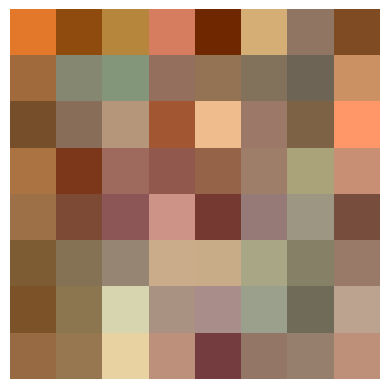

Model accuracy with adversarial patch: 13.20%
Untargeted attack success rate on test set: 86.80%
Targeted attack success rate on test set for class 5: 79.54%

------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [14]:
# Generate targeted adversarial patch
patch_targeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5)

# Visualize the generated patch
visualize_patch(patch_targeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [15]:
def plot_targeted_asr_vs_patch_size(model, target_class):
  print(f"\nRUNNING EXPERIMENTS FOR TARGET CLASS {target_class}\n")
  patch_sizes = [3, 5, 7, 16]
  targetted_asr_results = {}
  for size in patch_sizes:
    patch = generate_adversarial_patch(model=model, patch_size=size, target_class=target_class)
    visualize_patch(patch)
    adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=target_class)
    targetted_asr_results[size] = targetted_asr
  plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)


RUNNING EXPERIMENTS FOR TARGET CLASS 0

Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 21.32
Accuracy: 0.3594

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 23.65
Accuracy: 0.3294

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 26.3
Accuracy: 0.3135

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 25.66
Accuracy: 0.3033

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 27.11
Accuracy: 0.2938

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 28.51
Accuracy: 0.2901

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 28.060000000000002
Accuracy: 0.2804

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 28.82
Accuracy: 0.2717

Epoch 9
Target class: 0
Percentage of samples predicted as target class 0: 29.18
Accuracy: 0.279

Epoch 10
Target class: 0
Percentage of samples predicted 

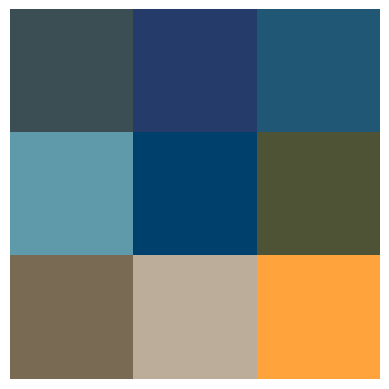

Model accuracy with adversarial patch: 29.52%
Untargeted attack success rate on test set: 70.48%
Targeted attack success rate on test set for class 0: 22.89%
Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 30.65
Accuracy: 0.3249

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 35.589999999999996
Accuracy: 0.2954

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 38.42
Accuracy: 0.2793

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 39.76
Accuracy: 0.2728

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 41.79
Accuracy: 0.2638

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 42.76
Accuracy: 0.2613

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 44.36
Accuracy: 0.2518

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 46.45
Accuracy: 0.2444

Epoch 9
Target class: 0
Percentage of

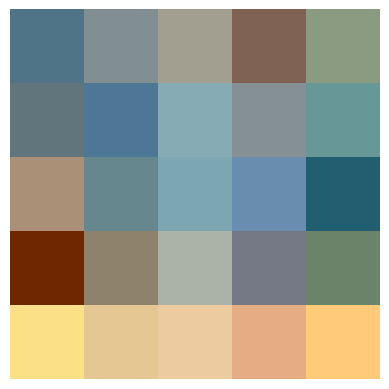

Model accuracy with adversarial patch: 26.48%
Untargeted attack success rate on test set: 73.52%
Targeted attack success rate on test set for class 0: 38.10%
Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 52.22
Accuracy: 0.2696

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 60.160000000000004
Accuracy: 0.2263

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 63.99
Accuracy: 0.2156

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 65.03
Accuracy: 0.2055

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 66.67999999999999
Accuracy: 0.2032

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 67.67999999999999
Accuracy: 0.1936

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 68.34
Accuracy: 0.1988

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 69.28
Accuracy: 0.1878

Epoch 9
Targe

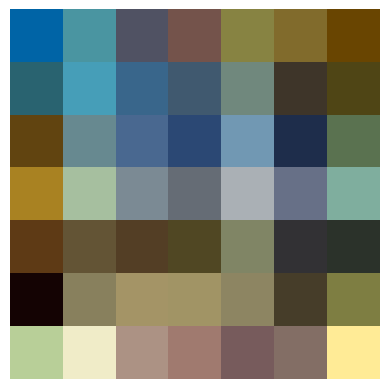

Model accuracy with adversarial patch: 20.85%
Untargeted attack success rate on test set: 79.15%
Targeted attack success rate on test set for class 0: 58.87%
Epoch 1
Target class: 0
Percentage of samples predicted as target class 0: 95.47
Accuracy: 0.1282

Epoch 2
Target class: 0
Percentage of samples predicted as target class 0: 98.50999999999999
Accuracy: 0.1102

Epoch 3
Target class: 0
Percentage of samples predicted as target class 0: 99.06
Accuracy: 0.1072

Epoch 4
Target class: 0
Percentage of samples predicted as target class 0: 99.32
Accuracy: 0.1059

Epoch 5
Target class: 0
Percentage of samples predicted as target class 0: 99.59
Accuracy: 0.1044

Epoch 6
Target class: 0
Percentage of samples predicted as target class 0: 99.6
Accuracy: 0.1037

Epoch 7
Target class: 0
Percentage of samples predicted as target class 0: 99.61
Accuracy: 0.1045

Epoch 8
Target class: 0
Percentage of samples predicted as target class 0: 99.79
Accuracy: 0.1024

Epoch 9
Target class: 0
Percentage of s

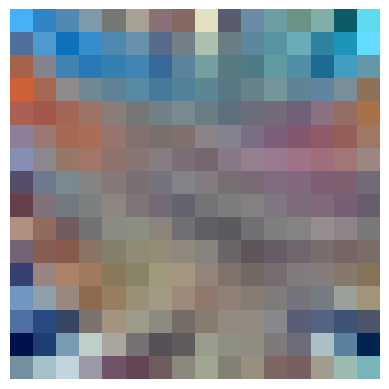

Model accuracy with adversarial patch: 10.21%
Untargeted attack success rate on test set: 89.79%
Targeted attack success rate on test set for class 0: 89.65%


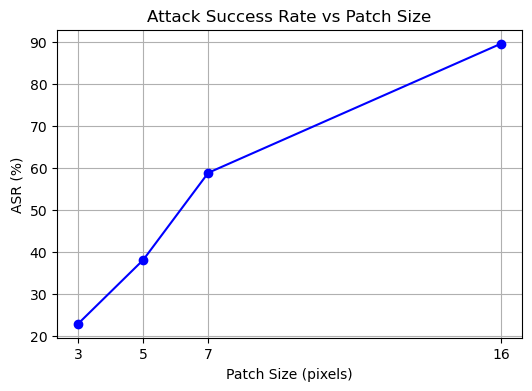


RUNNING EXPERIMENTS FOR TARGET CLASS 1

Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 48.339999999999996
Accuracy: 0.259

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 56.08
Accuracy: 0.2156

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 60.9
Accuracy: 0.1899

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 63.31
Accuracy: 0.1791

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 64.4
Accuracy: 0.1685

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 65.9
Accuracy: 0.1669

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 66.93
Accuracy: 0.164

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 67.28
Accuracy: 0.1616

Epoch 9
Target class: 1
Percentage of samples predicted as target class 1: 68.36
Accuracy: 0.1617

Epoch 10
Target class: 1
Percentage of samples predicted as 

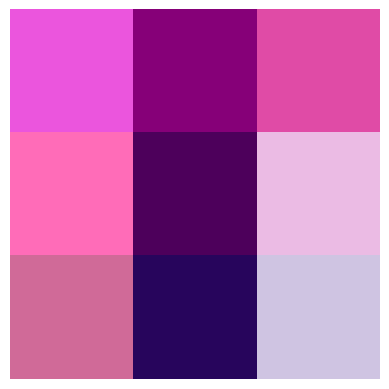

Model accuracy with adversarial patch: 16.74%
Untargeted attack success rate on test set: 83.26%
Targeted attack success rate on test set for class 1: 57.09%
Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 69.39999999999999
Accuracy: 0.1816

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 75.59
Accuracy: 0.1516

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 77.71000000000001
Accuracy: 0.1511

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 79.51
Accuracy: 0.1453

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 81.51
Accuracy: 0.1355

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 81.89999999999999
Accuracy: 0.1346

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 81.82000000000001
Accuracy: 0.1331

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 82.61
Accuracy: 0.1284

Ep

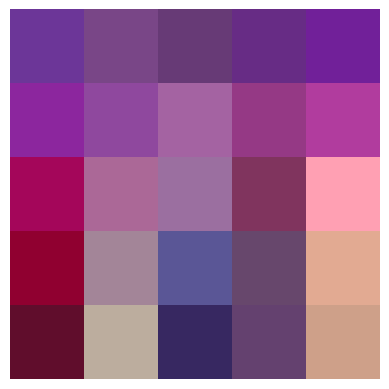

Model accuracy with adversarial patch: 12.93%
Untargeted attack success rate on test set: 87.07%
Targeted attack success rate on test set for class 1: 73.29%
Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 76.14999999999999
Accuracy: 0.1601

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 84.56
Accuracy: 0.137

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 87.1
Accuracy: 0.1268

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 88.11
Accuracy: 0.1261

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 89.67
Accuracy: 0.1224

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 90.48
Accuracy: 0.1199

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 91.22
Accuracy: 0.1193

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 92.27
Accuracy: 0.1143

Epoch 9
Target class: 1
Percentage of sa

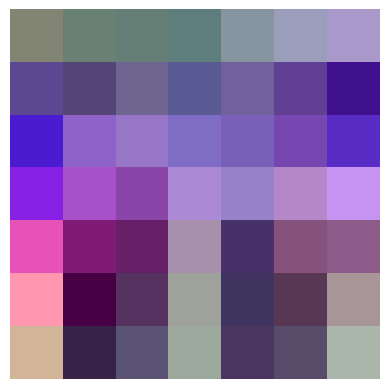

Model accuracy with adversarial patch: 11.55%
Untargeted attack success rate on test set: 88.45%
Targeted attack success rate on test set for class 1: 82.34%
Epoch 1
Target class: 1
Percentage of samples predicted as target class 1: 99.75
Accuracy: 0.1039

Epoch 2
Target class: 1
Percentage of samples predicted as target class 1: 99.91
Accuracy: 0.103

Epoch 3
Target class: 1
Percentage of samples predicted as target class 1: 99.92999999999999
Accuracy: 0.103

Epoch 4
Target class: 1
Percentage of samples predicted as target class 1: 99.94
Accuracy: 0.1027

Epoch 5
Target class: 1
Percentage of samples predicted as target class 1: 99.97
Accuracy: 0.1026

Epoch 6
Target class: 1
Percentage of samples predicted as target class 1: 99.97
Accuracy: 0.1026

Epoch 7
Target class: 1
Percentage of samples predicted as target class 1: 99.96000000000001
Accuracy: 0.1027

Epoch 8
Target class: 1
Percentage of samples predicted as target class 1: 99.98
Accuracy: 0.1025

Epoch 9
Target class: 1
Perc

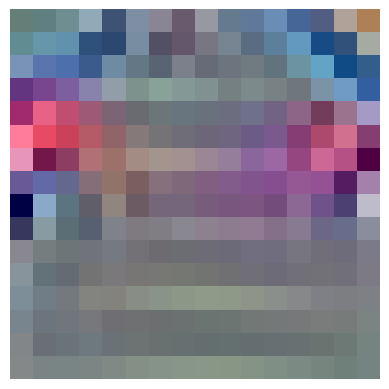

Model accuracy with adversarial patch: 10.04%
Untargeted attack success rate on test set: 89.96%
Targeted attack success rate on test set for class 1: 89.96%


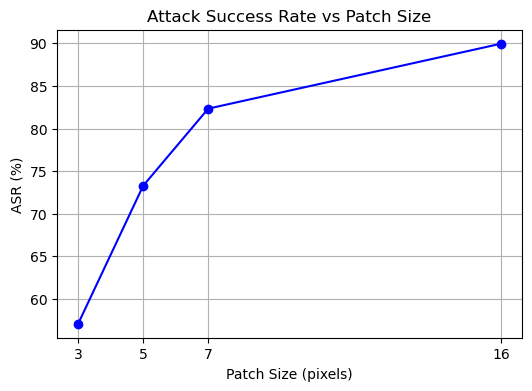


RUNNING EXPERIMENTS FOR TARGET CLASS 2

Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 69.67999999999999
Accuracy: 0.2661

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 78.36999999999999
Accuracy: 0.2116

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 81.17
Accuracy: 0.1947

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 83.42
Accuracy: 0.1742

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 84.57000000000001
Accuracy: 0.173

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 85.81
Accuracy: 0.1638

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 86.1
Accuracy: 0.1626

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 87.3
Accuracy: 0.1568

Epoch 9
Target class: 2
Percentage of samples predicted as target class 2: 87.85
Accuracy: 0.1504

Epoch 10
Target class: 2
Percentage

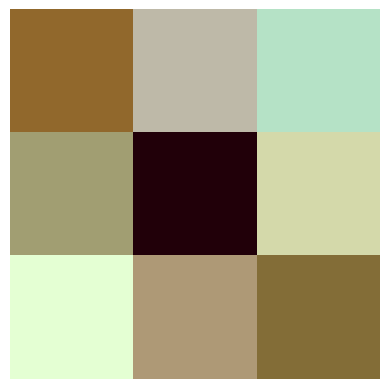

Model accuracy with adversarial patch: 15.32%
Untargeted attack success rate on test set: 84.68%
Targeted attack success rate on test set for class 2: 77.60%
Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 88.27000000000001
Accuracy: 0.1731

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 92.64
Accuracy: 0.1461

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 94.87
Accuracy: 0.1339

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 95.33
Accuracy: 0.1306

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 96.0
Accuracy: 0.1266

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 96.53
Accuracy: 0.124

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 96.82
Accuracy: 0.122

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 97.28999999999999
Accuracy: 0.118

Epoch 9
Target class: 2
Percen

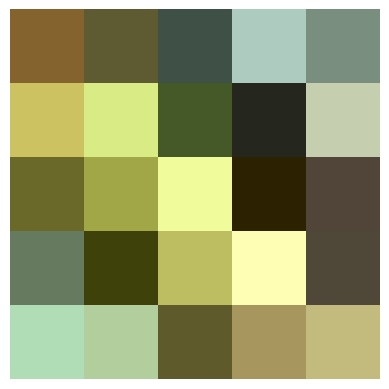

Model accuracy with adversarial patch: 11.98%
Untargeted attack success rate on test set: 88.02%
Targeted attack success rate on test set for class 2: 86.85%
Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 83.28
Accuracy: 0.1965

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 89.49000000000001
Accuracy: 0.1584

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 92.91
Accuracy: 0.1386

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 94.15
Accuracy: 0.1344

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 95.49
Accuracy: 0.126

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 96.41
Accuracy: 0.12

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 96.82
Accuracy: 0.1209

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 97.3
Accuracy: 0.1184

Epoch 9
Target class: 2
Percentage of samp

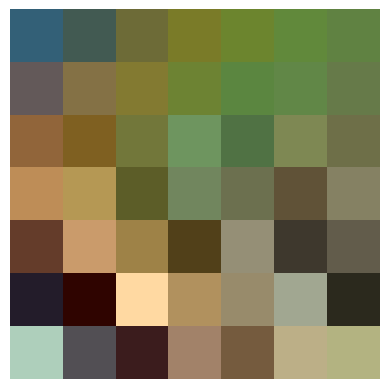

Model accuracy with adversarial patch: 11.41%
Untargeted attack success rate on test set: 88.59%
Targeted attack success rate on test set for class 2: 87.67%
Epoch 1
Target class: 2
Percentage of samples predicted as target class 2: 98.63
Accuracy: 0.1125

Epoch 2
Target class: 2
Percentage of samples predicted as target class 2: 99.42999999999999
Accuracy: 0.1068

Epoch 3
Target class: 2
Percentage of samples predicted as target class 2: 99.65
Accuracy: 0.1048

Epoch 4
Target class: 2
Percentage of samples predicted as target class 2: 99.72
Accuracy: 0.1049

Epoch 5
Target class: 2
Percentage of samples predicted as target class 2: 99.81
Accuracy: 0.104

Epoch 6
Target class: 2
Percentage of samples predicted as target class 2: 99.8
Accuracy: 0.104

Epoch 7
Target class: 2
Percentage of samples predicted as target class 2: 99.82
Accuracy: 0.1042

Epoch 8
Target class: 2
Percentage of samples predicted as target class 2: 99.81
Accuracy: 0.104

Epoch 9
Target class: 2
Percentage of samp

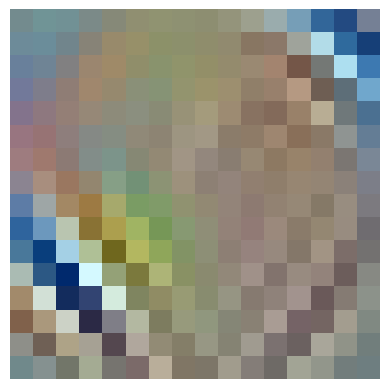

Model accuracy with adversarial patch: 10.09%
Untargeted attack success rate on test set: 89.91%
Targeted attack success rate on test set for class 2: 89.86%


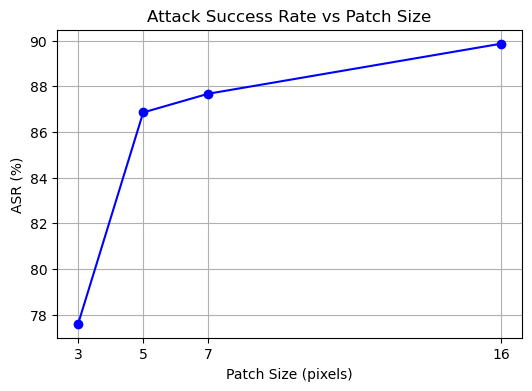


RUNNING EXPERIMENTS FOR TARGET CLASS 3

Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 28.42
Accuracy: 0.3439

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 46.63
Accuracy: 0.2866

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 52.86
Accuracy: 0.2553

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 55.97
Accuracy: 0.2303

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 57.63
Accuracy: 0.226

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 59.089999999999996
Accuracy: 0.2189

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 59.81999999999999
Accuracy: 0.2124

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 60.51
Accuracy: 0.2095

Epoch 9
Target class: 3
Percentage of samples predicted as target class 3: 61.59
Accuracy: 0.2011

Epoch 10
Target class: 3
Percentage of sampl

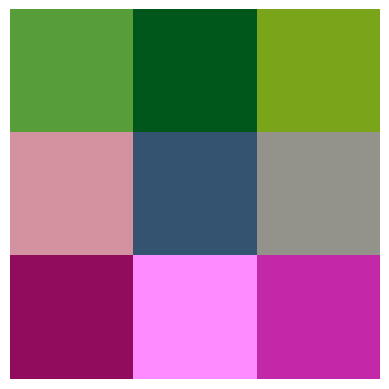

Model accuracy with adversarial patch: 22.47%
Untargeted attack success rate on test set: 77.53%
Targeted attack success rate on test set for class 3: 51.94%
Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 73.53
Accuracy: 0.1908

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 78.42
Accuracy: 0.1591

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 80.44
Accuracy: 0.1456

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 81.82000000000001
Accuracy: 0.1478

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 82.88
Accuracy: 0.1383

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 83.81
Accuracy: 0.1377

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 85.07000000000001
Accuracy: 0.1317

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 85.11999999999999
Accuracy: 0.1321

Epoch 9
Target

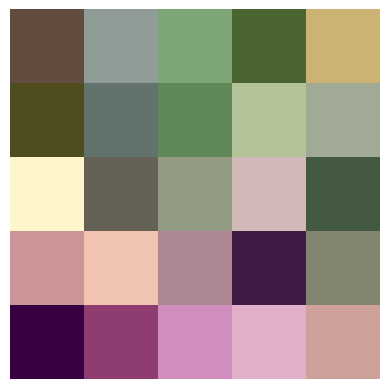

Model accuracy with adversarial patch: 14.07%
Untargeted attack success rate on test set: 85.93%
Targeted attack success rate on test set for class 3: 75.76%
Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 90.64999999999999
Accuracy: 0.1314

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 93.10000000000001
Accuracy: 0.1194

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 93.87
Accuracy: 0.1126

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 94.63000000000001
Accuracy: 0.1132

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 95.02000000000001
Accuracy: 0.1109

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 95.71
Accuracy: 0.1067

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 95.50999999999999
Accuracy: 0.1082

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 96.0
Accuracy:

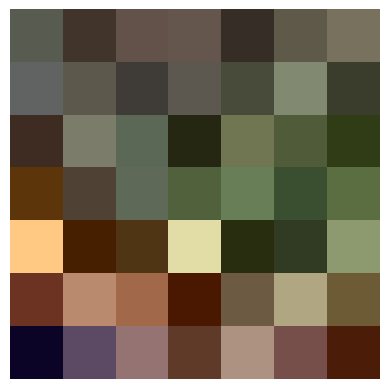

Model accuracy with adversarial patch: 11.06%
Untargeted attack success rate on test set: 88.94%
Targeted attack success rate on test set for class 3: 86.24%
Epoch 1
Target class: 3
Percentage of samples predicted as target class 3: 99.37
Accuracy: 0.1017

Epoch 2
Target class: 3
Percentage of samples predicted as target class 3: 99.62
Accuracy: 0.1003

Epoch 3
Target class: 3
Percentage of samples predicted as target class 3: 99.85000000000001
Accuracy: 0.0984

Epoch 4
Target class: 3
Percentage of samples predicted as target class 3: 99.88
Accuracy: 0.0981

Epoch 5
Target class: 3
Percentage of samples predicted as target class 3: 99.87
Accuracy: 0.0981

Epoch 6
Target class: 3
Percentage of samples predicted as target class 3: 99.86
Accuracy: 0.098

Epoch 7
Target class: 3
Percentage of samples predicted as target class 3: 99.9
Accuracy: 0.0976

Epoch 8
Target class: 3
Percentage of samples predicted as target class 3: 99.92999999999999
Accuracy: 0.0977

Epoch 9
Target class: 3
Perc

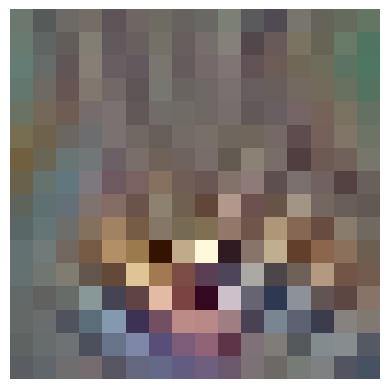

Model accuracy with adversarial patch: 10.09%
Untargeted attack success rate on test set: 89.91%
Targeted attack success rate on test set for class 3: 89.90%


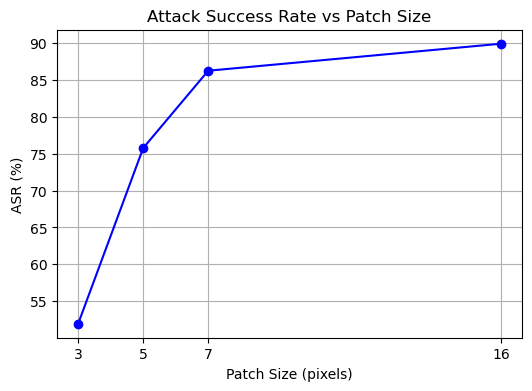


RUNNING EXPERIMENTS FOR TARGET CLASS 4

Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 6.35
Accuracy: 0.5482

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 5.92
Accuracy: 0.5341

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 5.6000000000000005
Accuracy: 0.5285

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 5.91
Accuracy: 0.5253

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 5.8500000000000005
Accuracy: 0.5234

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 5.6899999999999995
Accuracy: 0.5167

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 5.75
Accuracy: 0.5186

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 5.8999999999999995
Accuracy: 0.5299

Epoch 9
Target class: 4
Percentage of samples predicted as target class 4: 5.92
Accuracy: 0.5203

Epoch 10
Target class

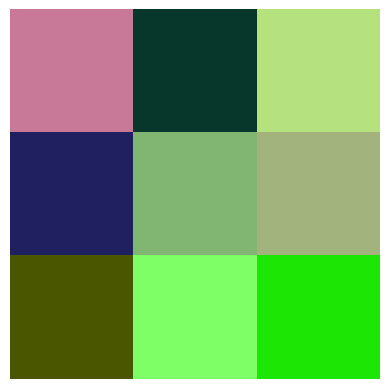

Model accuracy with adversarial patch: 56.06%
Untargeted attack success rate on test set: 43.94%
Targeted attack success rate on test set for class 4: 2.04%
Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 17.32
Accuracy: 0.4482

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 21.68
Accuracy: 0.39

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 22.29
Accuracy: 0.3908

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 22.13
Accuracy: 0.3785

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 23.23
Accuracy: 0.3707

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 23.3
Accuracy: 0.3756

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 23.669999999999998
Accuracy: 0.3594

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 23.880000000000003
Accuracy: 0.3628

Epoch 9
Target class: 4
Perc

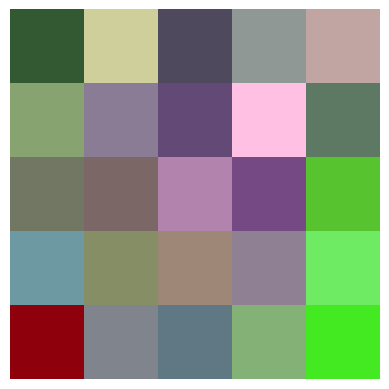

Model accuracy with adversarial patch: 40.27%
Untargeted attack success rate on test set: 59.73%
Targeted attack success rate on test set for class 4: 17.66%
Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 32.879999999999995
Accuracy: 0.335

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 39.57
Accuracy: 0.2858

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 43.41
Accuracy: 0.2706

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 44.61
Accuracy: 0.263

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 46.589999999999996
Accuracy: 0.252

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 48.89
Accuracy: 0.2441

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 49.0
Accuracy: 0.2453

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 49.65
Accuracy: 0.2438

Epoch 9
Target class: 4
Perc

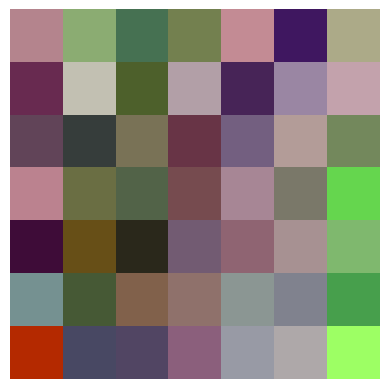

Model accuracy with adversarial patch: 26.25%
Untargeted attack success rate on test set: 73.75%
Targeted attack success rate on test set for class 4: 42.27%
Epoch 1
Target class: 4
Percentage of samples predicted as target class 4: 96.14
Accuracy: 0.1176

Epoch 2
Target class: 4
Percentage of samples predicted as target class 4: 98.13
Accuracy: 0.1085

Epoch 3
Target class: 4
Percentage of samples predicted as target class 4: 98.82
Accuracy: 0.1057

Epoch 4
Target class: 4
Percentage of samples predicted as target class 4: 99.36
Accuracy: 0.1025

Epoch 5
Target class: 4
Percentage of samples predicted as target class 4: 99.37
Accuracy: 0.1022

Epoch 6
Target class: 4
Percentage of samples predicted as target class 4: 99.57000000000001
Accuracy: 0.1019

Epoch 7
Target class: 4
Percentage of samples predicted as target class 4: 99.57000000000001
Accuracy: 0.1011

Epoch 8
Target class: 4
Percentage of samples predicted as target class 4: 99.68
Accuracy: 0.1009

Epoch 9
Target class: 4
Pe

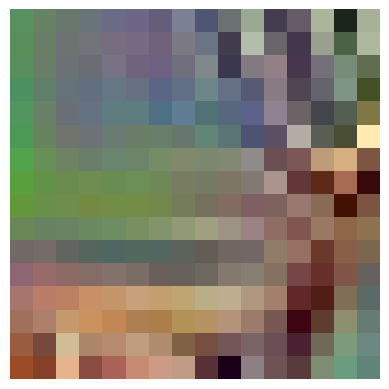

Model accuracy with adversarial patch: 10.27%
Untargeted attack success rate on test set: 89.73%
Targeted attack success rate on test set for class 4: 89.60%


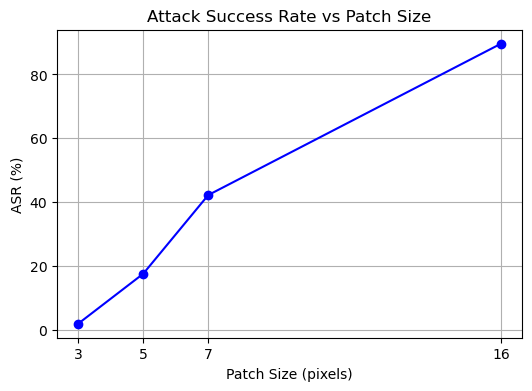


RUNNING EXPERIMENTS FOR TARGET CLASS 5

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 39.06
Accuracy: 0.2746

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 39.79
Accuracy: 0.2615

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 40.86
Accuracy: 0.2571

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 39.56
Accuracy: 0.2433

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 39.51
Accuracy: 0.2452

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 39.78
Accuracy: 0.2469

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 38.67
Accuracy: 0.2423

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 38.940000000000005
Accuracy: 0.2458

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 38.67
Accuracy: 0.2531

Epoch 10
Target class: 5
Percentage of samples predicte

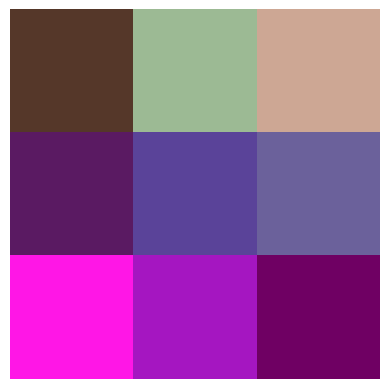

Model accuracy with adversarial patch: 27.99%
Untargeted attack success rate on test set: 72.01%
Targeted attack success rate on test set for class 5: 29.30%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 64.91
Accuracy: 0.2047

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 69.22
Accuracy: 0.1659

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 71.41999999999999
Accuracy: 0.1616

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 72.75
Accuracy: 0.1579

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 73.77
Accuracy: 0.1545

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 73.57000000000001
Accuracy: 0.1515

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 74.99
Accuracy: 0.1467

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 76.0
Accuracy: 0.1461

Epoch 9
Target class: 5
Per

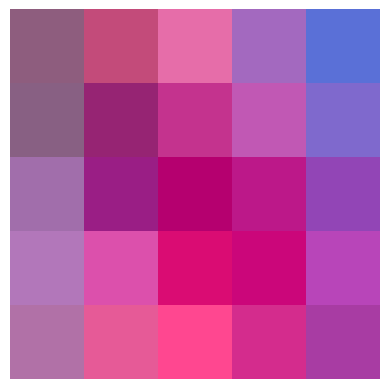

Model accuracy with adversarial patch: 14.49%
Untargeted attack success rate on test set: 85.51%
Targeted attack success rate on test set for class 5: 67.26%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 72.3
Accuracy: 0.182

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 75.18
Accuracy: 0.1658

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 77.24
Accuracy: 0.1556

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 78.68
Accuracy: 0.1509

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 79.25999999999999
Accuracy: 0.1503

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 79.32000000000001
Accuracy: 0.1472

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 79.56
Accuracy: 0.148

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 80.41
Accuracy: 0.1386

Epoch 9
Target class: 5
Perce

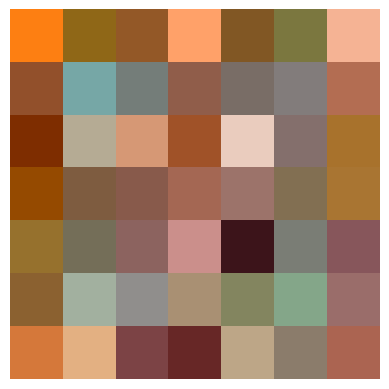

Model accuracy with adversarial patch: 15.38%
Untargeted attack success rate on test set: 84.62%
Targeted attack success rate on test set for class 5: 70.68%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 99.15
Accuracy: 0.109

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 99.6
Accuracy: 0.1051

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 99.65
Accuracy: 0.105

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 99.81
Accuracy: 0.1033

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 99.85000000000001
Accuracy: 0.1034

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 99.74
Accuracy: 0.1043

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 99.85000000000001
Accuracy: 0.1033

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 99.88
Accuracy: 0.103

Epoch 9
Target class: 5
Percen

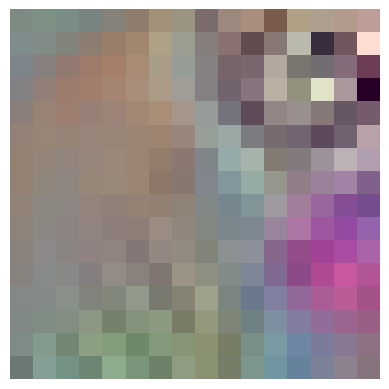

Model accuracy with adversarial patch: 10.05%
Untargeted attack success rate on test set: 89.95%
Targeted attack success rate on test set for class 5: 89.95%


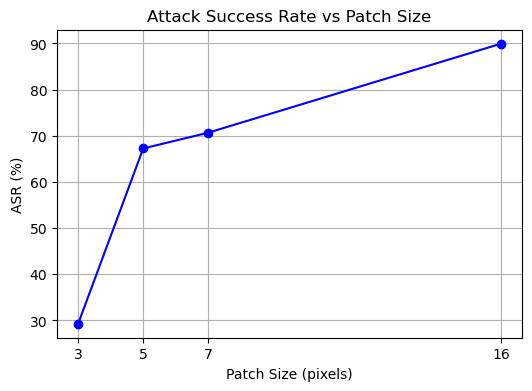


RUNNING EXPERIMENTS FOR TARGET CLASS 6

Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 35.19
Accuracy: 0.3725

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 38.24
Accuracy: 0.3199

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 37.97
Accuracy: 0.3014

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 38.67
Accuracy: 0.2896

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 39.160000000000004
Accuracy: 0.2768

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 38.800000000000004
Accuracy: 0.2757

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 40.25
Accuracy: 0.2751

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 39.18
Accuracy: 0.2636

Epoch 9
Target class: 6
Percentage of samples predicted as target class 6: 40.589999999999996
Accuracy: 0.2601

Epoch 10
Target class: 6
Perc

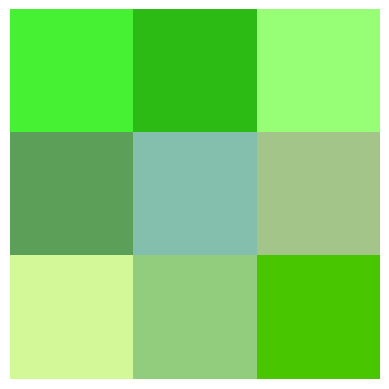

Model accuracy with adversarial patch: 30.29%
Untargeted attack success rate on test set: 69.71%
Targeted attack success rate on test set for class 6: 27.02%
Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 57.57
Accuracy: 0.2493

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 61.9
Accuracy: 0.214

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 65.13
Accuracy: 0.1916

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 65.58
Accuracy: 0.1827

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 67.0
Accuracy: 0.1743

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 67.73
Accuracy: 0.1758

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 69.38
Accuracy: 0.1673

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 69.15
Accuracy: 0.1698

Epoch 9
Target class: 6
Percentage of samples predict

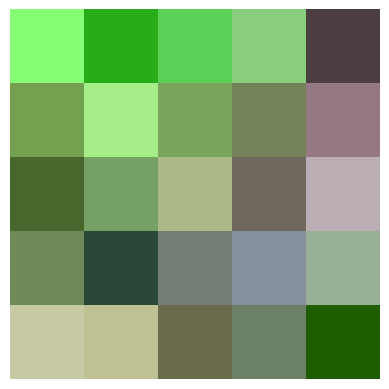

Model accuracy with adversarial patch: 18.15%
Untargeted attack success rate on test set: 81.85%
Targeted attack success rate on test set for class 6: 56.27%
Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 75.81
Accuracy: 0.1807

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 81.54
Accuracy: 0.1512

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 83.39999999999999
Accuracy: 0.1444

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 85.13
Accuracy: 0.1375

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 86.56
Accuracy: 0.1293

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 87.03999999999999
Accuracy: 0.1325

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 87.59
Accuracy: 0.1258

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 88.21
Accuracy: 0.1228

Epoch 9
Target class: 6
Pe

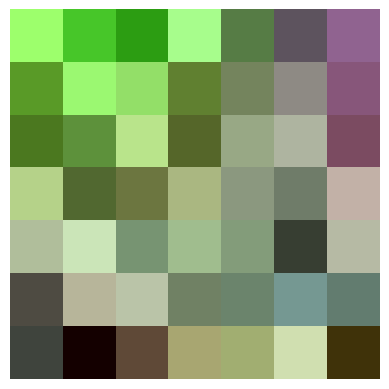

Model accuracy with adversarial patch: 13.60%
Untargeted attack success rate on test set: 86.40%
Targeted attack success rate on test set for class 6: 76.97%
Epoch 1
Target class: 6
Percentage of samples predicted as target class 6: 98.92999999999999
Accuracy: 0.104

Epoch 2
Target class: 6
Percentage of samples predicted as target class 6: 99.56
Accuracy: 0.0992

Epoch 3
Target class: 6
Percentage of samples predicted as target class 6: 99.67
Accuracy: 0.0986

Epoch 4
Target class: 6
Percentage of samples predicted as target class 6: 99.82
Accuracy: 0.0976

Epoch 5
Target class: 6
Percentage of samples predicted as target class 6: 99.86
Accuracy: 0.097

Epoch 6
Target class: 6
Percentage of samples predicted as target class 6: 99.86
Accuracy: 0.0972

Epoch 7
Target class: 6
Percentage of samples predicted as target class 6: 99.87
Accuracy: 0.0969

Epoch 8
Target class: 6
Percentage of samples predicted as target class 6: 99.92999999999999
Accuracy: 0.0967

Epoch 9
Target class: 6
Perc

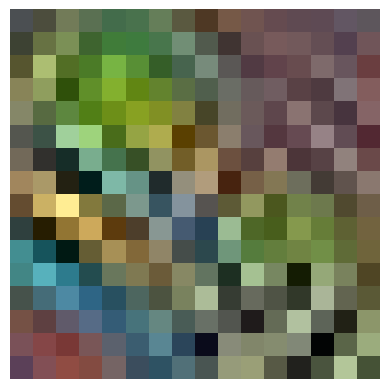

Model accuracy with adversarial patch: 10.14%
Untargeted attack success rate on test set: 89.86%
Targeted attack success rate on test set for class 6: 89.84%


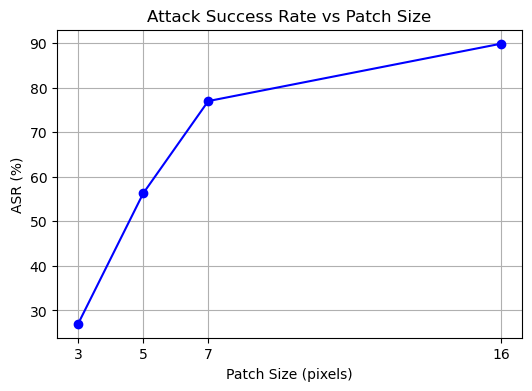


RUNNING EXPERIMENTS FOR TARGET CLASS 7

Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 8.41
Accuracy: 0.4733

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 7.470000000000001
Accuracy: 0.4231

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 7.89
Accuracy: 0.4147

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 7.739999999999999
Accuracy: 0.407

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 7.62
Accuracy: 0.4109

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 7.32
Accuracy: 0.4065

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 7.449999999999999
Accuracy: 0.404

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 7.109999999999999
Accuracy: 0.4084

Epoch 9
Target class: 7
Percentage of samples predicted as target class 7: 7.4399999999999995
Accuracy: 0.3989

Epoch 10
Targ

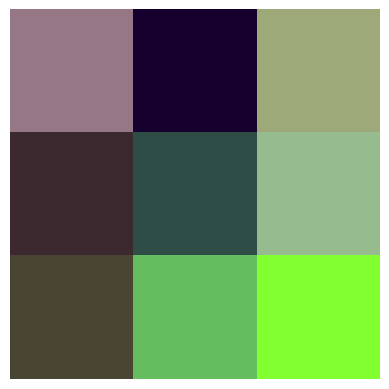

Model accuracy with adversarial patch: 42.66%
Untargeted attack success rate on test set: 57.34%
Targeted attack success rate on test set for class 7: 2.76%
Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 13.76
Accuracy: 0.4018

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 13.94
Accuracy: 0.3521

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 14.399999999999999
Accuracy: 0.3374

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 14.580000000000002
Accuracy: 0.3334

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 14.860000000000001
Accuracy: 0.3329

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 15.43
Accuracy: 0.3327

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 15.459999999999999
Accuracy: 0.3302

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 16.07
Accuracy: 0.3313


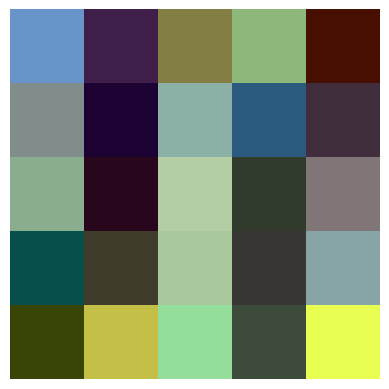

Model accuracy with adversarial patch: 35.89%
Untargeted attack success rate on test set: 64.11%
Targeted attack success rate on test set for class 7: 10.40%
Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 41.099999999999994
Accuracy: 0.3311

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 50.33
Accuracy: 0.27

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 56.38999999999999
Accuracy: 0.2505

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 62.53999999999999
Accuracy: 0.2185

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 66.77
Accuracy: 0.2047

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 70.26
Accuracy: 0.1914

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 71.7
Accuracy: 0.1844

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 73.78
Accuracy: 0.1813

Epoch 9
Target c

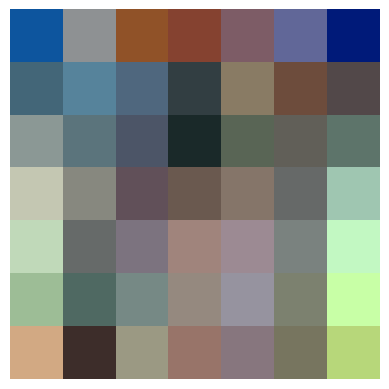

Model accuracy with adversarial patch: 19.23%
Untargeted attack success rate on test set: 80.77%
Targeted attack success rate on test set for class 7: 62.52%
Epoch 1
Target class: 7
Percentage of samples predicted as target class 7: 97.23
Accuracy: 0.1124

Epoch 2
Target class: 7
Percentage of samples predicted as target class 7: 99.03
Accuracy: 0.1054

Epoch 3
Target class: 7
Percentage of samples predicted as target class 7: 99.36
Accuracy: 0.1049

Epoch 4
Target class: 7
Percentage of samples predicted as target class 7: 99.72
Accuracy: 0.1032

Epoch 5
Target class: 7
Percentage of samples predicted as target class 7: 99.65
Accuracy: 0.1035

Epoch 6
Target class: 7
Percentage of samples predicted as target class 7: 99.67
Accuracy: 0.1033

Epoch 7
Target class: 7
Percentage of samples predicted as target class 7: 99.82
Accuracy: 0.1026

Epoch 8
Target class: 7
Percentage of samples predicted as target class 7: 99.85000000000001
Accuracy: 0.1023

Epoch 9
Target class: 7
Percentage of 

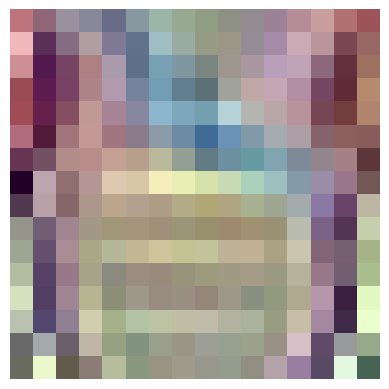

Model accuracy with adversarial patch: 10.13%
Untargeted attack success rate on test set: 89.87%
Targeted attack success rate on test set for class 7: 89.78%


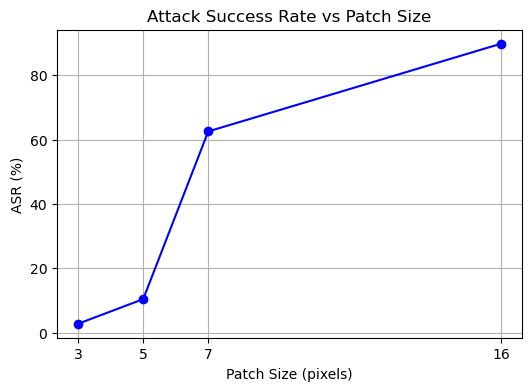


RUNNING EXPERIMENTS FOR TARGET CLASS 8

Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 4.55
Accuracy: 0.505

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 5.24
Accuracy: 0.4482

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 5.390000000000001
Accuracy: 0.4285

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 5.62
Accuracy: 0.4177

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 6.17
Accuracy: 0.4149

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 6.25
Accuracy: 0.4046

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 6.52
Accuracy: 0.3995

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 6.9
Accuracy: 0.3882

Epoch 9
Target class: 8
Percentage of samples predicted as target class 8: 6.4
Accuracy: 0.3896

Epoch 10
Target class: 8
Percentage of samples predicted as target 

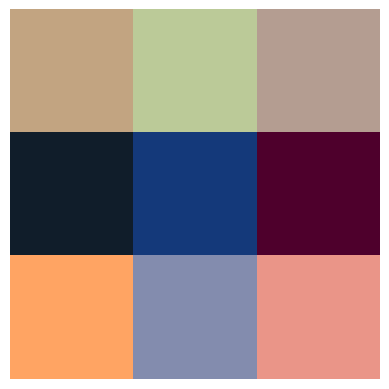

Model accuracy with adversarial patch: 41.70%
Untargeted attack success rate on test set: 58.30%
Targeted attack success rate on test set for class 8: 2.43%
Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 15.590000000000002
Accuracy: 0.4041

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 22.39
Accuracy: 0.321

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 26.35
Accuracy: 0.2979

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 29.599999999999998
Accuracy: 0.2755

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 30.159999999999997
Accuracy: 0.2678

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 31.509999999999998
Accuracy: 0.2624

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 32.029999999999994
Accuracy: 0.2553

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 32.12999999

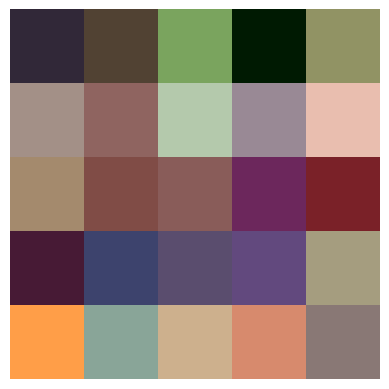

Model accuracy with adversarial patch: 26.72%
Untargeted attack success rate on test set: 73.28%
Targeted attack success rate on test set for class 8: 24.28%
Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 41.699999999999996
Accuracy: 0.2986

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 57.43000000000001
Accuracy: 0.2289

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 65.66
Accuracy: 0.2002

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 69.38
Accuracy: 0.1829

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 72.54
Accuracy: 0.1748

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 73.88
Accuracy: 0.1614

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 73.66
Accuracy: 0.1642

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 75.33999999999999
Accuracy: 0.1597

Epoch 9
Targe

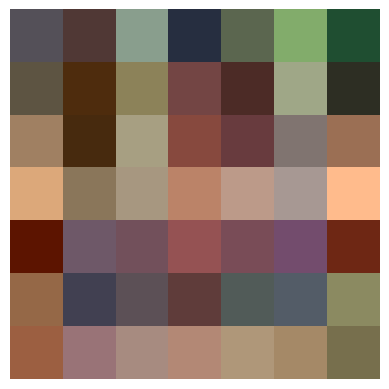

Model accuracy with adversarial patch: 16.33%
Untargeted attack success rate on test set: 83.67%
Targeted attack success rate on test set for class 8: 65.63%
Epoch 1
Target class: 8
Percentage of samples predicted as target class 8: 93.86
Accuracy: 0.1321

Epoch 2
Target class: 8
Percentage of samples predicted as target class 8: 97.31
Accuracy: 0.116

Epoch 3
Target class: 8
Percentage of samples predicted as target class 8: 98.11
Accuracy: 0.1106

Epoch 4
Target class: 8
Percentage of samples predicted as target class 8: 98.85000000000001
Accuracy: 0.1068

Epoch 5
Target class: 8
Percentage of samples predicted as target class 8: 98.94
Accuracy: 0.1064

Epoch 6
Target class: 8
Percentage of samples predicted as target class 8: 99.27
Accuracy: 0.1045

Epoch 7
Target class: 8
Percentage of samples predicted as target class 8: 99.4
Accuracy: 0.104

Epoch 8
Target class: 8
Percentage of samples predicted as target class 8: 99.33
Accuracy: 0.1041

Epoch 9
Target class: 8
Percentage of sam

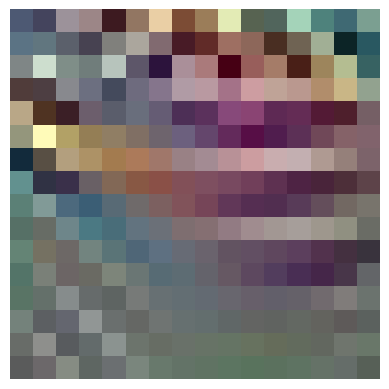

Model accuracy with adversarial patch: 10.40%
Untargeted attack success rate on test set: 89.60%
Targeted attack success rate on test set for class 8: 89.43%


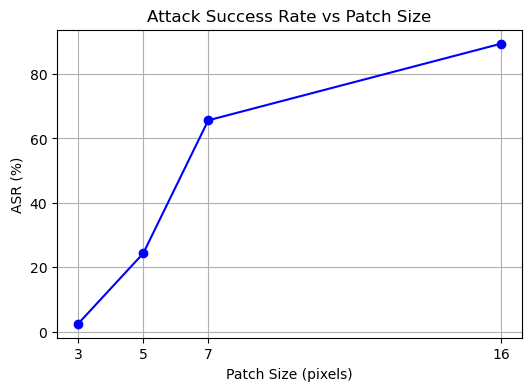


RUNNING EXPERIMENTS FOR TARGET CLASS 9

Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 12.23
Accuracy: 0.3839

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 17.78
Accuracy: 0.3253

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 19.139999999999997
Accuracy: 0.3207

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 20.05
Accuracy: 0.3141

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 21.029999999999998
Accuracy: 0.3138

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 21.09
Accuracy: 0.3079

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 21.02
Accuracy: 0.2974

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 21.85
Accuracy: 0.2973

Epoch 9
Target class: 9
Percentage of samples predicted as target class 9: 21.14
Accuracy: 0.3039

Epoch 10
Target class: 9
Percentage of sam

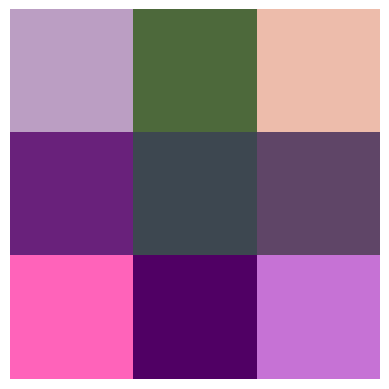

Model accuracy with adversarial patch: 32.00%
Untargeted attack success rate on test set: 68.00%
Targeted attack success rate on test set for class 9: 14.19%
Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 31.369999999999997
Accuracy: 0.2847

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 56.21000000000001
Accuracy: 0.2356

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 61.739999999999995
Accuracy: 0.218

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 62.92
Accuracy: 0.2164

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 63.21
Accuracy: 0.2047

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 63.88
Accuracy: 0.1928

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 64.75999999999999
Accuracy: 0.1885

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 63.88
Accuracy: 0.1884

E

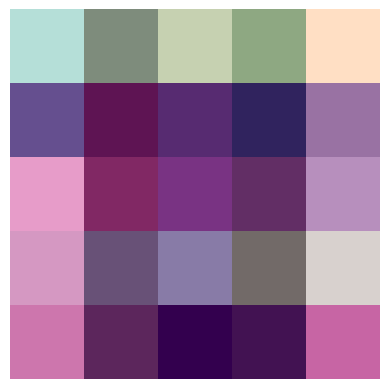

Model accuracy with adversarial patch: 19.33%
Untargeted attack success rate on test set: 80.67%
Targeted attack success rate on test set for class 9: 55.88%
Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 80.11
Accuracy: 0.1805

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 83.25
Accuracy: 0.1573

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 86.0
Accuracy: 0.1452

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 86.74
Accuracy: 0.142

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 86.81
Accuracy: 0.1391

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 87.39
Accuracy: 0.1358

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 87.82
Accuracy: 0.1338

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 88.49000000000001
Accuracy: 0.131

Epoch 9
Target class: 9
Percentage of sam

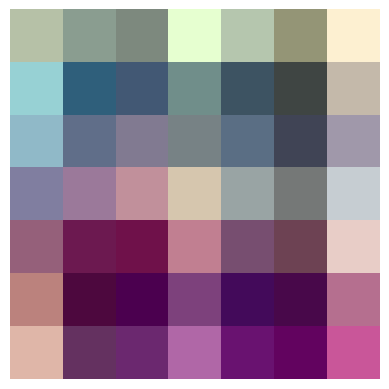

Model accuracy with adversarial patch: 13.10%
Untargeted attack success rate on test set: 86.90%
Targeted attack success rate on test set for class 9: 78.68%
Epoch 1
Target class: 9
Percentage of samples predicted as target class 9: 99.41
Accuracy: 0.1033

Epoch 2
Target class: 9
Percentage of samples predicted as target class 9: 99.75
Accuracy: 0.1007

Epoch 3
Target class: 9
Percentage of samples predicted as target class 9: 99.83999999999999
Accuracy: 0.1

Epoch 4
Target class: 9
Percentage of samples predicted as target class 9: 99.89
Accuracy: 0.0993

Epoch 5
Target class: 9
Percentage of samples predicted as target class 9: 99.83999999999999
Accuracy: 0.0994

Epoch 6
Target class: 9
Percentage of samples predicted as target class 9: 99.9
Accuracy: 0.0995

Epoch 7
Target class: 9
Percentage of samples predicted as target class 9: 99.92999999999999
Accuracy: 0.0992

Epoch 8
Target class: 9
Percentage of samples predicted as target class 9: 99.92
Accuracy: 0.0994

Epoch 9
Target cla

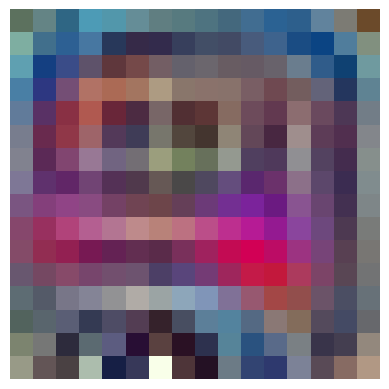

Model accuracy with adversarial patch: 10.07%
Untargeted attack success rate on test set: 89.93%
Targeted attack success rate on test set for class 9: 89.92%


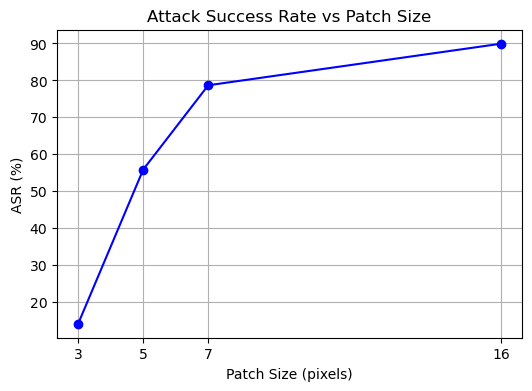


------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [16]:
for target_class in range(10):
  plot_targeted_asr_vs_patch_size(resnet18, target_class)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

## Experiment 4: Transferring patches to other models

In [18]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet50, num_epochs=30, model_path="resnet50.pth")

# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO RESNET50")

# Untargeted Attack
test(model=resnet50, patch=patch_untargeted_size8, target_class=None)

# Targeted Attack
test(model=resnet50, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

Epoch 1: Training accuracy = 0.547
Validation accuracy: 0.7062
Saved new best model with accuracy: 0.7062
Epoch 2: Training accuracy = 0.60245
Validation accuracy: 0.682
Epoch 3: Training accuracy = 0.71735
Validation accuracy: 0.7142
Saved new best model with accuracy: 0.7142
Epoch 4: Training accuracy = 0.7559
Validation accuracy: 0.7326
Saved new best model with accuracy: 0.7326
Epoch 5: Training accuracy = 0.7787
Validation accuracy: 0.7625
Saved new best model with accuracy: 0.7625
Epoch 6: Training accuracy = 0.796475
Validation accuracy: 0.791
Saved new best model with accuracy: 0.7910
Epoch 7: Training accuracy = 0.808225
Validation accuracy: 0.7974
Saved new best model with accuracy: 0.7974
Epoch 8: Training accuracy = 0.819675
Validation accuracy: 0.7878
Epoch 9: Training accuracy = 0.8262
Validation accuracy: 0.8029
Saved new best model with accuracy: 0.8029
Epoch 10: Training accuracy = 0.835425
Validation accuracy: 0.8326
Saved new best model with accuracy: 0.8326
Epoch 11

### Test untarget & target attack on VGG19

In [19]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")

# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth")

# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO VGG19")

# Untargeted Attack
test(model=vgg19, patch=patch_untargeted_size8, target_class=None)

# Targeted Attack
test(model=vgg19, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

Epoch 1: Training accuracy = 0.393325
Validation accuracy: 0.6185
Saved new best model with accuracy: 0.6185
Epoch 2: Training accuracy = 0.707075
Validation accuracy: 0.7441
Saved new best model with accuracy: 0.7441
Epoch 3: Training accuracy = 0.772625
Validation accuracy: 0.7834
Saved new best model with accuracy: 0.7834
Epoch 4: Training accuracy = 0.80265
Validation accuracy: 0.7847
Saved new best model with accuracy: 0.7847
Epoch 5: Training accuracy = 0.821475
Validation accuracy: 0.837
Saved new best model with accuracy: 0.8370
Epoch 6: Training accuracy = 0.838525
Validation accuracy: 0.8381
Saved new best model with accuracy: 0.8381
Epoch 7: Training accuracy = 0.8508
Validation accuracy: 0.8256
Epoch 8: Training accuracy = 0.85845
Validation accuracy: 0.8016
Epoch 9: Training accuracy = 0.863925
Validation accuracy: 0.8423
Saved new best model with accuracy: 0.8423
Epoch 10: Training accuracy = 0.875675
Validation accuracy: 0.86
Saved new best model with accuracy: 0.8600
Ep

### Test untarget & target attack on DenseNet121

In [29]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
fine_tune_for_cifar10(model=densenet121, num_epochs=60, model_path="densenet121.pth",lr=0.05)

# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth")
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO DENSENET121")

# Untargeted Attack
test(model=densenet121, patch=patch_untargeted_size8, target_class=None)
# Targeted Attack
test(model=densenet121, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

Epoch 1: Training accuracy = 0.199975
Validation accuracy: 0.2494
Saved new best model with accuracy: 0.2494
Epoch 2: Training accuracy = 0.276025
Validation accuracy: 0.3075
Saved new best model with accuracy: 0.3075
Epoch 3: Training accuracy = 0.319575
Validation accuracy: 0.3356
Saved new best model with accuracy: 0.3356
Epoch 4: Training accuracy = 0.349175
Validation accuracy: 0.3519
Saved new best model with accuracy: 0.3519
Epoch 5: Training accuracy = 0.377475
Validation accuracy: 0.3796
Saved new best model with accuracy: 0.3796
Epoch 6: Training accuracy = 0.396125
Validation accuracy: 0.4139
Saved new best model with accuracy: 0.4139
Epoch 7: Training accuracy = 0.415225
Validation accuracy: 0.4185
Saved new best model with accuracy: 0.4185
Epoch 8: Training accuracy = 0.42435
Validation accuracy: 0.4358
Saved new best model with accuracy: 0.4358
Epoch 9: Training accuracy = 0.43755
Validation accuracy: 0.4504
Saved new best model with accuracy: 0.4504
Epoch 10: Training ac

In [41]:
from tabulate import tabulate

# Define the table data
table_data = [
    ["Model", "Model Accuracy", "Untargeted ASR", "Targeted ASR"],
    ["ResNet18", 0.8314, 0.6688, 0.7954],
    ["ResNet50", 0.8680, 0.5792, 0.1465],
    ["VGG19", 0.8843, 0.6252, 0.0892],
    ["DenseNet121", 0.7008, 0.5744, 0.0423]

]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


+-------------+------------------+------------------+----------------+
| Model       |   Model Accuracy |   Untargeted ASR |   Targeted ASR |
+=============+==================+==================+================+
| ResNet18    |           0.8314 |           0.6688 |         0.7954 |
+-------------+------------------+------------------+----------------+
| ResNet50    |           0.868  |           0.5792 |         0.1465 |
+-------------+------------------+------------------+----------------+
| VGG19       |           0.8843 |           0.6252 |         0.0892 |
+-------------+------------------+------------------+----------------+
| DenseNet121 |           0.7008 |           0.5744 |         0.0423 |
+-------------+------------------+------------------+----------------+


## Experiment 5: Creating patches that are robust to more transformations

In [30]:
# Apply patch to a batch of images with additional transformations (rotation, horizontal flip, vertical flip, color inversion)
def apply_extension(patch, batch_of_images):
    num_images = batch_of_images.shape[0]
    patch_size = patch.shape[1]

    # Iterate through each image in the batch
    for i in range(num_images):
        # Rotate the patch by a random number of degrees
        degree = random.uniform(0, 360)
        patch_rotated = TF.rotate(patch, angle=degree)

        # Apply horizontal flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.hflip(patch_rotated)

        # Apply vertical flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.vflip(patch_rotated)

        # Apply color inversion with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.invert(patch_rotated)

        # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
        # This coordinate will be where the top left corner of the rotated patch goes
        top_left_x = random.randint(0, 31 - patch_size)
        top_left_y = random.randint(0, 31 - patch_size)

        # Apply the randomly transformed patch at the random location
        batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch_rotated

    return batch_of_images


In [31]:
# # Load pre-trained model
# resnet18ex = models.resnet18(weights="DEFAULT")

# # ResNet is trained on ImageNet, which has 1000 classes
# # So we need to modify the output layer for CIFAR-10, which has 10 classes
# resnet18ex.fc = nn.Linear(resnet18ex.fc.in_features, 10)

# # Finetune the model
# fine_tune_for_cifar10(model=resnet18ex, num_epochs=30, model_path="resnet18ex.pth")
# # Load best model checkpoint
# resnet18ex = load_model(resnet18ex, "resnet18ex.pth", device=device)
# # Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

Model accuracy on clean test set: 83.14%


(0.8314, 0.1686)

Epoch 1
Target class: None
Accuracy: 0.4424

Epoch 2
Target class: None
Accuracy: 0.3977

Epoch 3
Target class: None
Accuracy: 0.3777

Epoch 4
Target class: None
Accuracy: 0.3286

Epoch 5
Target class: None
Accuracy: 0.3326

Epoch 6
Target class: None
Accuracy: 0.3202

Epoch 7
Target class: None
Accuracy: 0.3138

Epoch 8
Target class: None
Accuracy: 0.3071

Epoch 9
Target class: None
Accuracy: 0.3028

Epoch 10
Target class: None
Accuracy: 0.295



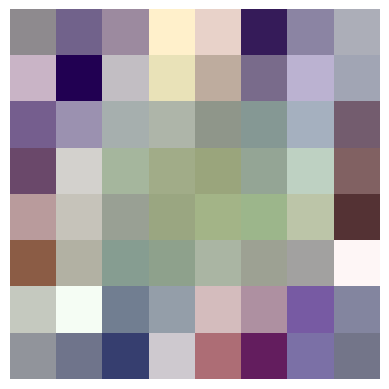

Model accuracy with adversarial patch: 32.73%
Untargeted attack success rate on test set: 67.27%

------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [32]:
# Generate adversarial patch
patch_untarget_ex = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_untarget_ex)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untarget_ex, target_class=None, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 51.76
Accuracy: 0.2409

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 44.42
Accuracy: 0.2527

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 40.75
Accuracy: 0.2434

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 39.910000000000004
Accuracy: 0.2383

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 41.61
Accuracy: 0.2428

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 40.97
Accuracy: 0.2399

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 42.57
Accuracy: 0.2346

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 43.8
Accuracy: 0.2319

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 44.2
Accuracy: 0.2338

Epoch 10
Target class: 5
Percentage of samples predicted as target class 5: 45.03
Accuracy: 0.2266

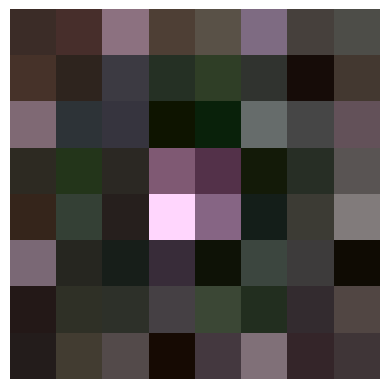

Model accuracy with adversarial patch: 24.95%
Untargeted attack success rate on test set: 75.05%
Targeted attack success rate on test set for class 5: 35.92%

------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [33]:
# Generate adversarial patch
patch_target_ex = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_target_ex)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [34]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
# fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")
# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth", device=device)
# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=vgg19, patch=patch_untarget_ex, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=vgg19, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

Model accuracy on clean test set: 88.43%
Model accuracy with adversarial patch: 30.70%
Untargeted attack success rate on test set: 69.30%
Model accuracy with adversarial patch: 50.04%
Untargeted attack success rate on test set: 49.96%
Targeted attack success rate on test set for class 5: 10.35%

------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [35]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
# fine_tune_for_cifar10(model=densenet121, num_epochs=30, model_path="densenet121.pth")
# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth", device=device)
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=densenet121, patch=patch_untarget_ex, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=densenet121, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

Model accuracy on clean test set: 70.08%
Model accuracy with adversarial patch: 42.50%
Untargeted attack success rate on test set: 57.50%
Model accuracy with adversarial patch: 47.72%
Untargeted attack success rate on test set: 52.28%
Targeted attack success rate on test set for class 5: 12.06%

------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [36]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)
# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=resnet50, patch=patch_untarget_ex, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=resnet50, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

Model accuracy on clean test set: 86.80%
Model accuracy with adversarial patch: 49.76%
Untargeted attack success rate on test set: 50.24%
Model accuracy with adversarial patch: 50.34%
Untargeted attack success rate on test set: 49.66%
Targeted attack success rate on test set for class 5: 21.93%

------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [42]:
# Define the table data
table_data = [
    ["Model", "Model Accuracy", "Untargeted ASR", "Targeted ASR"],
    ["ResNet18", 0.8314, 0.6727, 0.3592],
    ["ResNet50", 0.8680, 0.5024, 0.2193],
    ["VGG19", 0.8843, 0.6930, 0.1035],
    ["DenseNet121", 0.7008, 0.5750, 0.1206]

]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


+-------------+------------------+------------------+----------------+
| Model       |   Model Accuracy |   Untargeted ASR |   Targeted ASR |
+=============+==================+==================+================+
| ResNet18    |           0.8314 |           0.6727 |         0.3592 |
+-------------+------------------+------------------+----------------+
| ResNet50    |           0.868  |           0.5024 |         0.2193 |
+-------------+------------------+------------------+----------------+
| VGG19       |           0.8843 |           0.693  |         0.1035 |
+-------------+------------------+------------------+----------------+
| DenseNet121 |           0.7008 |           0.575  |         0.1206 |
+-------------+------------------+------------------+----------------+


### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. untargeted ASR.

Epoch 1
Target class: None
Accuracy: 0.442

Epoch 2
Target class: None
Accuracy: 0.4343

Epoch 3
Target class: None
Accuracy: 0.4389

Epoch 4
Target class: None
Accuracy: 0.4405

Epoch 5
Target class: None
Accuracy: 0.4269

Epoch 6
Target class: None
Accuracy: 0.4259

Epoch 7
Target class: None
Accuracy: 0.4266

Epoch 8
Target class: None
Accuracy: 0.4186

Epoch 9
Target class: None
Accuracy: 0.4347

Epoch 10
Target class: None
Accuracy: 0.4118



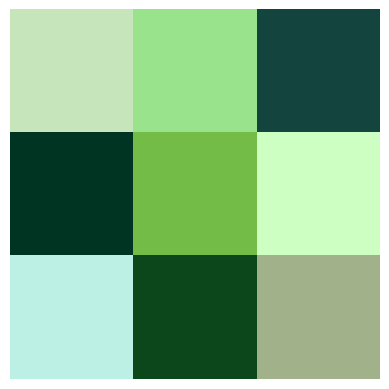

Model accuracy with adversarial patch: 40.75%
Untargeted attack success rate on test set: 59.25%
Epoch 1
Target class: None
Accuracy: 0.359

Epoch 2
Target class: None
Accuracy: 0.34

Epoch 3
Target class: None
Accuracy: 0.3382

Epoch 4
Target class: None
Accuracy: 0.3276

Epoch 5
Target class: None
Accuracy: 0.3353

Epoch 6
Target class: None
Accuracy: 0.3094

Epoch 7
Target class: None
Accuracy: 0.3112

Epoch 8
Target class: None
Accuracy: 0.3019

Epoch 9
Target class: None
Accuracy: 0.3031

Epoch 10
Target class: None
Accuracy: 0.3024



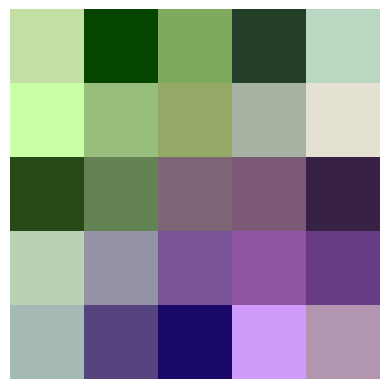

Model accuracy with adversarial patch: 38.45%
Untargeted attack success rate on test set: 61.55%
Epoch 1
Target class: None
Accuracy: 0.3809

Epoch 2
Target class: None
Accuracy: 0.355

Epoch 3
Target class: None
Accuracy: 0.34

Epoch 4
Target class: None
Accuracy: 0.324

Epoch 5
Target class: None
Accuracy: 0.3161

Epoch 6
Target class: None
Accuracy: 0.3088

Epoch 7
Target class: None
Accuracy: 0.3095

Epoch 8
Target class: None
Accuracy: 0.303

Epoch 9
Target class: None
Accuracy: 0.3121

Epoch 10
Target class: None
Accuracy: 0.3059



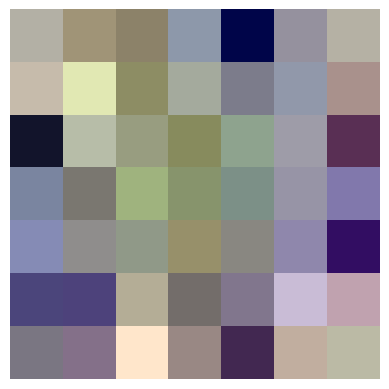

Model accuracy with adversarial patch: 33.59%
Untargeted attack success rate on test set: 66.41%
Epoch 1
Target class: None
Accuracy: 0.4768

Epoch 2
Target class: None
Accuracy: 0.4488

Epoch 3
Target class: None
Accuracy: 0.4236

Epoch 4
Target class: None
Accuracy: 0.3854

Epoch 5
Target class: None
Accuracy: 0.3716

Epoch 6
Target class: None
Accuracy: 0.3733

Epoch 7
Target class: None
Accuracy: 0.3528

Epoch 8
Target class: None
Accuracy: 0.2832

Epoch 9
Target class: None
Accuracy: 0.2532

Epoch 10
Target class: None
Accuracy: 0.2466



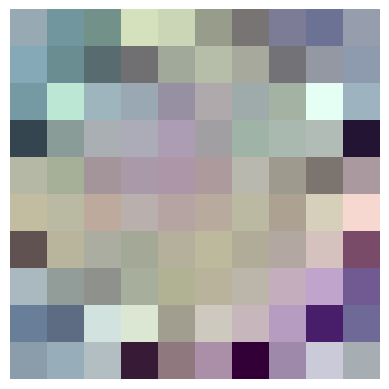

Model accuracy with adversarial patch: 32.44%
Untargeted attack success rate on test set: 67.56%
Epoch 1
Target class: None
Accuracy: 0.5154

Epoch 2
Target class: None
Accuracy: 0.4225

Epoch 3
Target class: None
Accuracy: 0.4043

Epoch 4
Target class: None
Accuracy: 0.384

Epoch 5
Target class: None
Accuracy: 0.3661

Epoch 6
Target class: None
Accuracy: 0.3335

Epoch 7
Target class: None
Accuracy: 0.3037

Epoch 8
Target class: None
Accuracy: 0.287

Epoch 9
Target class: None
Accuracy: 0.2715

Epoch 10
Target class: None
Accuracy: 0.2381



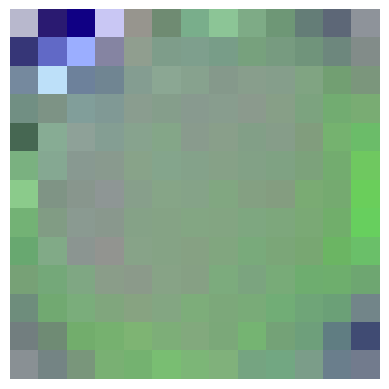

Model accuracy with adversarial patch: 38.06%
Untargeted attack success rate on test set: 61.94%
Epoch 1
Target class: None
Accuracy: 0.3811

Epoch 2
Target class: None
Accuracy: 0.2963

Epoch 3
Target class: None
Accuracy: 0.2427

Epoch 4
Target class: None
Accuracy: 0.2237

Epoch 5
Target class: None
Accuracy: 0.2067

Epoch 6
Target class: None
Accuracy: 0.2015

Epoch 7
Target class: None
Accuracy: 0.2014

Epoch 8
Target class: None
Accuracy: 0.1969

Epoch 9
Target class: None
Accuracy: 0.1999

Epoch 10
Target class: None
Accuracy: 0.1956



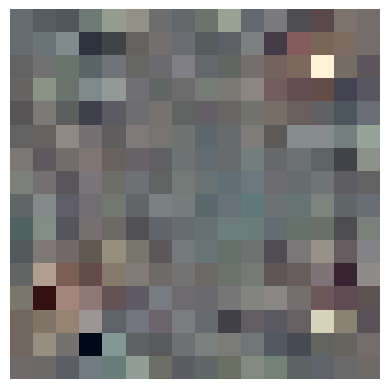

Model accuracy with adversarial patch: 23.42%
Untargeted attack success rate on test set: 76.58%


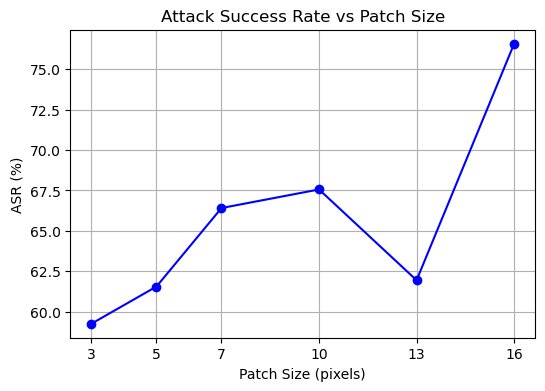


------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [38]:
patch_sizes = [3, 5, 7, 10, 13, 16]
untargetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=None, num_epochs=10,\
                                      lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch, target_class=None, apply=apply_extension)
  untargetted_asr_results[size] = untargetted_asr
plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. targeted ASR. Target class is set to 5 here.

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 28.76
Accuracy: 0.2992

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 30.020000000000003
Accuracy: 0.2744

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 30.930000000000003
Accuracy: 0.2843

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 30.48
Accuracy: 0.2798

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 30.9
Accuracy: 0.2858

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 30.78
Accuracy: 0.2866

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 30.509999999999998
Accuracy: 0.2866

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 30.15
Accuracy: 0.2817

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 29.580000000000002
Accuracy: 0.292

Epoch 10
Target class: 5
Percentage of samples predicted as

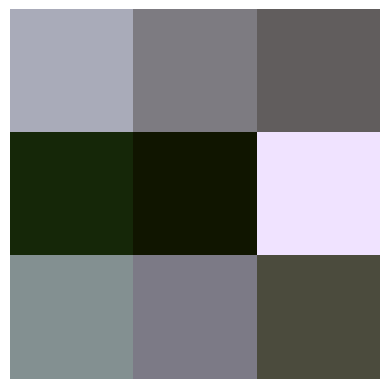

Model accuracy with adversarial patch: 33.85%
Untargeted attack success rate on test set: 66.15%
Targeted attack success rate on test set for class 5: 21.77%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 61.160000000000004
Accuracy: 0.2098

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 64.25999999999999
Accuracy: 0.1848

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 65.51
Accuracy: 0.1766

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 67.06
Accuracy: 0.1693

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 66.4
Accuracy: 0.1656

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 67.75
Accuracy: 0.1649

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 67.36
Accuracy: 0.1626

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 67.38
Accuracy: 0.1641

Epoch 9
Target class: 5
Pe

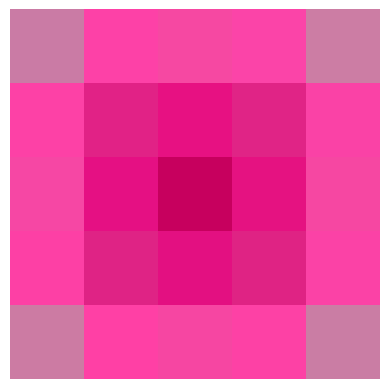

Model accuracy with adversarial patch: 19.10%
Untargeted attack success rate on test set: 80.90%
Targeted attack success rate on test set for class 5: 43.38%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 46.160000000000004
Accuracy: 0.2229

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 46.71
Accuracy: 0.2181

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 46.93
Accuracy: 0.2155

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 47.42
Accuracy: 0.2127

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 48.309999999999995
Accuracy: 0.2089

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 48.02
Accuracy: 0.2111

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 48.91
Accuracy: 0.2076

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 48.84
Accuracy: 0.2103

Epoch 9
Target class: 5


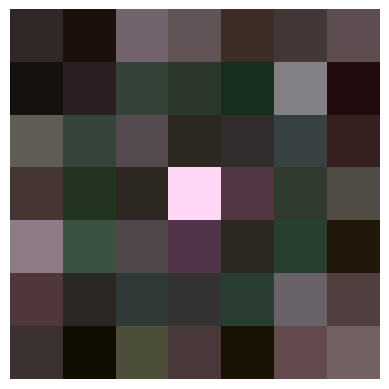

Model accuracy with adversarial patch: 26.16%
Untargeted attack success rate on test set: 73.84%
Targeted attack success rate on test set for class 5: 32.98%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 66.97999999999999
Accuracy: 0.1922

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 63.5
Accuracy: 0.1932

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 66.47
Accuracy: 0.1876

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 67.81
Accuracy: 0.1898

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 68.06
Accuracy: 0.1838

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 70.19999999999999
Accuracy: 0.1803

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 70.35
Accuracy: 0.1792

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 69.98
Accuracy: 0.1802

Epoch 9
Target class: 5
Per

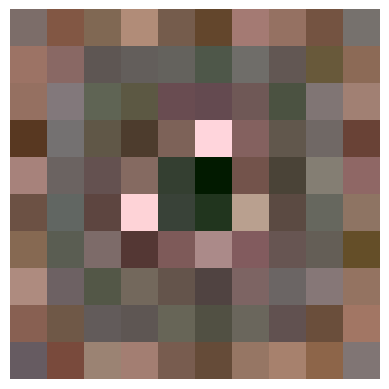

Model accuracy with adversarial patch: 22.86%
Untargeted attack success rate on test set: 77.14%
Targeted attack success rate on test set for class 5: 42.56%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 6.77
Accuracy: 0.6075

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 74.68
Accuracy: 0.184

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 75.51
Accuracy: 0.171

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 76.13
Accuracy: 0.1641

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 78.28
Accuracy: 0.164

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 78.64
Accuracy: 0.1657

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 77.35
Accuracy: 0.1706

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 79.7
Accuracy: 0.1619

Epoch 9
Target class: 5
Percentage of samples predicted

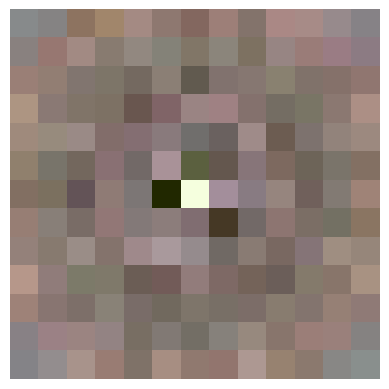

Model accuracy with adversarial patch: 18.60%
Untargeted attack success rate on test set: 81.40%
Targeted attack success rate on test set for class 5: 53.67%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 48.980000000000004
Accuracy: 0.2832

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 81.94
Accuracy: 0.1705

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 88.0
Accuracy: 0.1527

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 91.46
Accuracy: 0.1381

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 92.99
Accuracy: 0.1343

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 93.84
Accuracy: 0.1323

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 94.96
Accuracy: 0.1289

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 95.34
Accuracy: 0.1254

Epoch 9
Target class: 5
Percentage of 

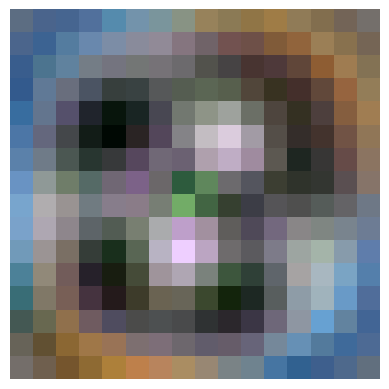

Model accuracy with adversarial patch: 16.68%
Untargeted attack success rate on test set: 83.32%
Targeted attack success rate on test set for class 5: 76.56%


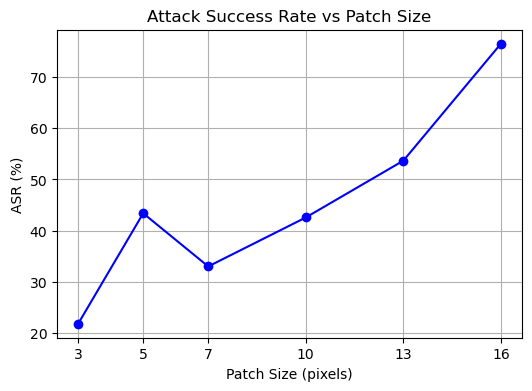


------------------------------------------------------------------------------------

Model accuracy on clean test set: 83.14%

------------------------------------------------------------------------------------



In [39]:
patch_sizes = [3, 5, 7, 10, 13, 16]
targetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=5, num_epochs=10, \
                                     lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=5, apply=apply_extension)
  targetted_asr_results[size] = targetted_asr
plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")